In [1]:
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import os
import sys
from numpy.fft import fft, ifft
import glob

In [2]:
def remove_periodic(X, df_index, detrending=True, model='additive', frequency_threshold=0.1e12):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    else:
        rad_trends = rad_series_clean
        
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    #rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    residual = rad - rad_clean_ts.values
    clean = rad_clean_ts.values
    return residual, clean

In [3]:
def load_data(path, resampling=None):
    ## some resampling options: 'H' - hourly, '15min' - 15 minutes, 'M' - montlhy
    ## more options at:
    ## http://benalexkeen.com/resampling-time-series-data-with-pandas/
    allFiles = glob.iglob(path + "/**/*.txt", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_,index_col="datetime",parse_dates=['datetime'], header=0, sep=",")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
    frame = pd.concat(list_)
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    frame = frame.fillna(method='ffill')
    return frame

In [4]:
def create_spatio_temporal_data(nrel_df):
    lat = [21.31236,21.31303,21.31357,21.31183,21.31042,21.31268,21.31451,21.31533,21.30812,21.31276,21.31281,21.30983,21.31141,21.31478,21.31179,21.31418,21.31034]
    lon = [-158.08463,-158.08505,-158.08424,-158.08554,-158.0853,-158.08688,-158.08534,-158.087,-158.07935,-158.08389,-158.08163,-158.08249,-158.07947,-158.07785,-158.08678,-158.08685,-158.08675]
    additional_info = pd.DataFrame({'station': df.columns, 'latitude': lat, 'longitude': lon })
    ll = []
    for ind, row in nrel_df.iterrows():
        for col in nrel_df.columns:
            lat = additional_info[(additional_info.station == col)].latitude.values[0]
            lon = additional_info[(additional_info.station == col)].longitude.values[0]
            irradiance = row[col]
            ll.append([lat, lon, irradiance])  

    return pd.DataFrame(columns=['latitude','longitude','irradiance'], data=ll)

In [5]:
path = '/Users/cseveriano/spatio-temporal-forecasting/data/processed/NREL/Oahu'

df = load_data(path)

# Corrigir ordem das colunas
df.columns = ['DHHL_3','DHHL_4', 'DHHL_5', 'DHHL_10', 'DHHL_11', 'DHHL_9', 'DHHL_2', 'DHHL_1', 'DHHL_1_Tilt', 'AP_6', 'AP_6_Tilt', 'AP_1', 'AP_3', 'AP_5', 'AP_4', 'AP_7', 'DHHL_6', 'DHHL_7', 'DHHL_8']
#inicio dos dados possui falhas na medicao
df = df.loc[df.index > '2010-03-20']
df.drop(['DHHL_1_Tilt', 'AP_6_Tilt'], axis=1, inplace=True)

## Preparação bases de treinamento e testes

In [6]:
clean_df = pd.DataFrame(columns=df.columns, index=df.index)
residual_df = pd.DataFrame(columns=df.columns, index=df.index)

for col in df.columns:
    residual, clean = remove_periodic(df[col].tolist(), df.index, frequency_threshold=0.01e12)
    clean_df[col] = clean.tolist()
    residual_df[col] = residual.tolist()

In [7]:
train_df = df[(df.index >= '2010-09-01') & (df.index <= '2011-09-01')]
train_clean_df = clean_df[(clean_df.index >= '2010-09-01') & (clean_df.index <= '2011-09-01')]
train_residual_df = residual_df[(residual_df.index >= '2010-09-01') & (residual_df.index <= '2011-09-01')]


test_df = df[(df.index >= '2010-08-05')& (df.index < '2010-08-06')]
test_clean_df = clean_df[(clean_df.index >= '2010-08-05')& (clean_df.index < '2010-08-06')]
test_residual_df = residual_df[(residual_df.index >= '2010-08-05')& (residual_df.index < '2010-08-06')]

In [8]:
# ms_df = create_spatio_temporal_data(train_residual_df)
# ms_df.to_pickle("cluster_df.pkl")

In [9]:
ms_df = pd.read_pickle("cluster_df.pkl")

In [10]:
from sklearn import preprocessing

X = ms_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

## Mini-batch KMeans


In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

Busca de melhor valor k com base no Sillouette Coefficient

Starting Loop


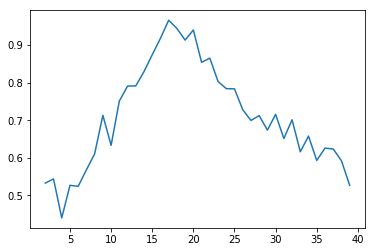

In [22]:
batch_size = 1000
init_size = 1000
range_n_clusters = np.arange(2,40)
print("Starting Loop")
results = []

for n_clusters in range_n_clusters:

#     print("Starting Mini-batch")
    clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size, init_size=init_size,
                      n_init=1, verbose=False)
#     print("Starting Fit predict")
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
#     print("Starting Silhouette")
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)
    results.append(silhouette_avg)

plt.plot(range_n_clusters,results)

In [25]:
print("Best value: ",max(results), "Number of clusters: ", range_n_clusters[np.argmax(results)])

Best value:  0.966338545956 Number of clusters:  17


For n_clusters = 17 The average silhouette_score is : 0.967117541554


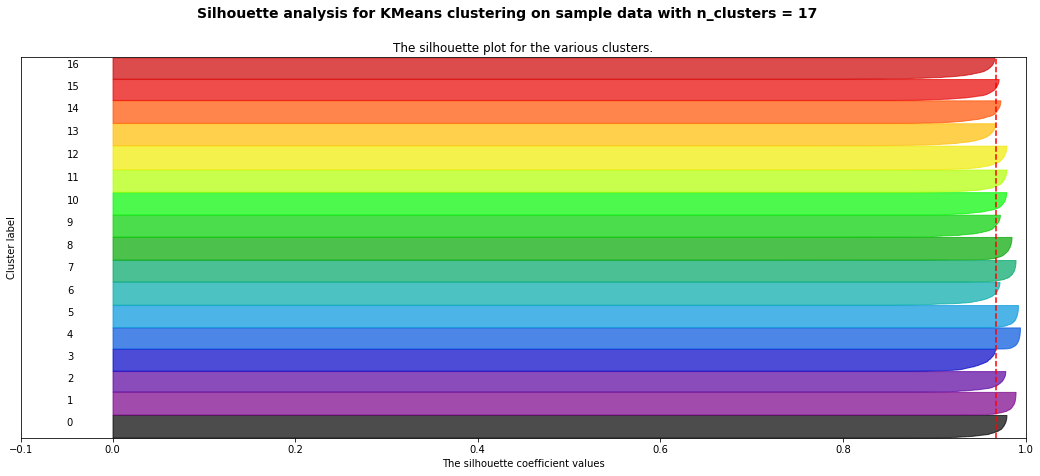

In [33]:
import matplotlib.cm as cm

n_clusters = 17
n_samples = 10000
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, n_samples + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size, init_size=init_size,
                      n_init=1, verbose=False)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels, sample_size=n_samples)
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

idx = np.random.choice(np.arange(len(X)), n_samples, replace=False)
x_sample = X[idx]
c_sample = cluster_labels[idx]


sample_silhouette_values = silhouette_samples(x_sample, c_sample)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[c_sample == i]


    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()